# Part 5: Model - Classification Analysis

Now let's switch gears and use a Classification Analysis to see if we can predict if a restaurant will get a high (4+) or low (0-3.5) Yelp rating based on metrics such as the inspection grade, the location, the number of reviews, the type of cuisine, etc. Understanding which features are most important in accurately predicting a Yelp rating can help restaurateurs figure out what they can do to put themselves in the best position to receive good Yelp reviews (i.e. be in a certain location, serve a certain type of food, etc.). Having a better Yelp review often can influence additional consumers to walk through your restaurant doors, which will lead to greater profits for the restuarant.

For this analysis, I have used classification, a type of supervised machine learning that uses labelled data to help predict which group a data point should be classified into. I will run 5 different classification models in order to determine which of the five would be most accurate and therefore should be utilized. The five classification models used are:

1. Decision Tree
2. Randoom Forest
3. Adaboost
4. XGBoost
5. Logistic Regression

Let's begin!

First, let's import the necessary libraries and our dataset which we scrubbed in our first notebook.

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
import itertools
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings('ignore')

# Libraries for machine learning modeling & confusion matrices
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [2]:
# Import Data:
with open ('scrubbed_data.pickle','rb') as f:
    df_merged = pickle.load(f)

print(len(df_merged))
df_merged.head()

3930


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,wine_bars,womenscloth,wraps,delivery,pickup,restaurant_reservation,num_of_cat,mainstream_category,rare_category,price_value
0,41322152,1 2 3 BURGER SHOT BEER,Manhattan,738,10 AVENUE,10019.0,(212) 315-0123,American,2019-12-20,Violations were cited in the following area(s).,...,0,0,0,1,1,0,3,1,0,1
1,41430594,1 STOP PATTY SHOP,Manhattan,1708,AMSTERDAM AVENUE,10031.0,(212) 491-7466,Bakery,2019-03-27,Violations were cited in the following area(s).,...,0,0,0,0,0,0,2,1,0,1
2,50059935,108 FOOD DRIED HOT POT,Manhattan,2794,BROADWAY,10025.0,(917) 675-6878,Chinese,2019-05-23,Violations were cited in the following area(s).,...,0,0,0,1,1,0,2,1,0,2
3,41092609,10TH AVENUE COOKSHOP,Manhattan,156,10 AVENUE,10011.0,(212) 924-4440,American,2019-04-11,Violations were cited in the following area(s).,...,1,0,0,1,1,0,3,1,0,2
4,50057272,11 HANOVER GREEK,Manhattan,11,HANOVER SQ,10005.0,(212) 785-4000,Greek,2019-02-28,Violations were cited in the following area(s).,...,1,0,0,1,1,0,3,1,0,3


Many of our data columns are currently filled with categorical data, which our model will be unable to read. Therefore, we have to update the data to be numerical. We will use one-hot encoding to turn each category within a column into its own column with numerical data that our model is able to properly use.

In [3]:
# Change the price column to be strings:
df_merged['price_value'].astype(str)

# Get dummy variables for categorical columns that have not yet been one-hot encoded:
df_merged = pd.get_dummies(df_merged, columns = ['GRADE', 'neighborhood', 'CRITICAL FLAG','count_range',
                          'price_value'])

Next, we will add in a column to represent our target which is either a high rating (4+) or a low rating (0-3.5). We will also break our data into train and test sets. Doing so helps ensure that we do not overfit or underfit our model.

In [4]:
# Convert ratings columns values so that the target variable will not be continuous: 
df_merged['high_rating'] = df_merged['rating'].apply(lambda x: 1 if x > 3.5 else 0)

# Identify our X and y variables:
X = df_merged.drop(columns=['CAMIS','DBA','BORO','BUILDING','STREET','ZIPCODE','display_phone','CUISINE DESCRIPTION',
                           'INSPECTION DATE','ACTION','SCORE','GRADE DATE','INSPECTION TYPE','Latitude','Longitude',
                           '#_of_inspections','name','price','rating','review_count','transactions',
                            'categories_clean','latitude','longitude','address','city','zip_code',
                            'state','num_of_cat','high_rating',],
                   axis=1)
y = df_merged.loc[:,'high_rating']

# Split into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

A few of our columns had very few data points in them. Once we split into training and testing data, we end up with certain columns having all of their data in one of the new train/test datasets and no values in the other dataset. Therefore, we will use the below function to remove all of the columns that have no data in them. We will remove these columns in both the training and testing datasets to ensure we still have the same columns present in each set.

In [5]:
# Create function that identifies columns with no entries:
def remove_columns(data):
    '''This function will take a dataset and identify any columns whose values sum to zero,
    indicating no data is present in the column.'''
    
    e_dataframe = []
    temp_dataframe = []
    columns = list(data.columns.values)

    for i in columns:
        if data[i].sum().any() == 0:
            e_dataframe.append(i)
        else:
            temp_dataframe.append(i)
    
    return e_dataframe

# Run function to identify columns that need to be removed for both X_train and X_test datasets
empty1 = remove_columns(X_train)
empty2 = remove_columns(X_test)

# Merge the two lists of columns that need to be removed. Use set() function to remove duplicates:
empty = list(set(empty1 + empty2))

# Drop columns that are included in the 'empty' list
X_train = X_train.drop(columns=empty,axis=1)
X_test = X_test.drop(columns=empty,axis=1)
X = X.drop(columns=empty,axis=1)

# Ensure our X_train and X_test sets have the same number of columns:
print('X_train # of columns:', len(X_train.columns),'\n','X_test # of columns:',len(X_test.columns),'\n',
      'X # of columns:',len(X.columns))

X_train # of columns: 195 
 X_test # of columns: 195 
 X # of columns: 195


A good visual way to visualize how accurate our model is is by referencing a confusion matrix. This is a table used to describe the performance of the model. The confusion matrix will show us how many of each of the below groupings the model gives us:

- **True Positives (TP)** - # of observations where model predicted a high rating and it actually was a high rating
- **True Negatives (TN)** - # of observations where model predicted a not a high rating and it actually was not a high rating
- **False Positive (FP)** - # of observations where model predicted a high rating but it actually was not a high rating
- **False Negative (FN)** - # of observations where model predicted a not high rating and it actually was a high rating

In [6]:
# Define Confusion Matrix:
def confusion_matrix_plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''This function will create a confusion matrix chart which shows the accuracy breakdown of the given model.
    Inputs:
        cm: confusion matrix function for tested and predicted y values
        classes: variables to identify for each class (0 or 1)
        normalize: if True will normalize the data, if False will not normalize the data
        title: title of the chart
        cmap: colors to plot
    Returns:
        A graph that represents the confusion matrix
    '''
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add title and labels:
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add axis scales and tick marks:
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add labels to each cell:
    thresh = cm.max() / 2.
    # Iterate through confusion matrix and append labels to the plot:
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    # Add legend:
    plt.colorbar()
    plt.show()
    
# Use High Rating and Low Rating  for 0 and 1 classes 
class_names = ['High Rating','Low Rating']

In addition to the confusion matrix, I will also use a classification report, which provides four key metrics in evaluating the performance of a model. The four metrics are:
1. Precision - measures how accurate the predictions are
> <br>Precision = TP / (TP + FP)<br>
2. Recall - % of positives correctly identified
> <br>Recall = TP / (TP + FN)<br>
3. F1-score - Harmonic mean of precision and recall.
> <br>F1-score = 2 x (precision x recall)/(precision + recall)
4. Support - # of samples of the true responses that are in the class.

Once we have identified our best model, we will then identify which specific features are most important. To do that, I will use the below function.

In [7]:
# Define function to show most important features both visually and in list form
def plot_feature_importances(df, model, num=30, return_list=False):
    '''
    Inputs:
       df : Dataframe to use 
       model : Specific Classification model to extract feature importances from
       num : Number of features that should be plotted
       return_list : If true, returns a list of the features identified as important
    
    Returns:
        Plots a bar graph showing feature importances of num features. Graph is in 
        descending order of feature importances
        If return_list = True, a list of sorted num features will be provided as well.
        
    '''
    feat_imp = dict(zip(df.columns, model.feature_importances_))
    data = sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)[:num]
        
    plt.barh([x[0] for x in data], [x[1] for x in data], align='center', color='darkolivegreen') 
    plt.xlabel("Feature importance", size=14)
    
    if return_list:
        return data

Now let's go ahead and run our models.

## 5.1 Decision Tree:
The decision tree model uses a tree-like structure to classify by efficiently partitioning each sample into sets with similar data points until you get to a homogenous set and can reasonably predict values for new data.

First, I will run a grid search to determine which parameters will optimize our model. This step will allow us to have a better chance at getting a more accurate model. Once I have the 'best parameters' identified, I can then utilize those in the decision tree classification. The parameters I will be adjusting are:

- *criterion:* measures the quality of the split by looking at impurity either through gini or entropy
- *max_depth:* maximum number of levels of a tree
- *min_samples_split:* minimum number of samples required to split an internal node

In [8]:
# Determine optimal parameters:
# Declare a baseline classifier:
dtree = DecisionTreeClassifier()

# Create the grid parameter:
grid_dtree = {'criterion': ["gini", "entropy"],
              'max_depth': range(1,10), 
              'min_samples_split': range(1,10)}


# Create the grid:
gs_dtree = GridSearchCV(estimator=dtree, 
                          param_grid=grid_dtree, 
                          scoring='accuracy', 
                          cv=5)

# Fit using grid search:
gs_dtree.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_dtree.best_score_)
print('\nBest params:\n', gs_dtree.best_params_)

Best accuracy: 0.675

Best params:
 {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 4}


Decision Tree Train Accuracy:  73.50054525627044 %
Decision Tree Test Accuracy:  70.22900763358778 %
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       438
           1       0.74      0.80      0.77       741

    accuracy                           0.70      1179
   macro avg       0.68      0.67      0.67      1179
weighted avg       0.70      0.70      0.70      1179



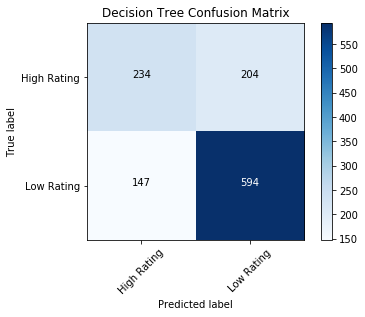

In [8]:
# Create the classifier, fit it on the training data and make predictions on the test set:
d_tree = DecisionTreeClassifier(criterion='gini',max_depth=9,min_samples_split=4, random_state=123)
d_tree = d_tree.fit(X_train, y_train)
y_pred_test_d_tree = d_tree.predict(X_test)
y_pred_train_d_tree = d_tree.predict(X_train)

print('Decision Tree Train Accuracy: ', accuracy_score(y_train, y_pred_train_d_tree)*100,'%')
print('Decision Tree Test Accuracy: ', accuracy_score(y_test, y_pred_test_d_tree)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred_test_d_tree))

# Confusion Matrix for Decision Tree
cm_dtree = confusion_matrix(y_test,y_pred_test_d_tree)
confusion_matrix_plot(cm_dtree, classes=class_names, title='Decision Tree Confusion Matrix')

## 5.2 Random Forest:
Random forests are an ensemble method for decision trees that both trains trees on different samples of data (bagging) and randomly selects a subset of features to use as predictors (subspace sampling method) to create a 'forest' of decision trees. This method typically gives better predictions than any single decision tree would.

We will again begin by finding the optimal parameters which will then be used in the classification model. The parameters used are:

- *n_estimators:* number of trees in the forest
- *criterion:* measures the quality of the split by looking at impurity either through gini or entropy
- *max_depth:* maximum number of levels of a tree
- *max_features:* maximum number of features to consider for splitting a node
- *min_samples_split:* minimum number of samples required to split an internal node

In [11]:
# Determine optimal parameters:
# Declare a baseline classifier:
forest = RandomForestClassifier()

# Create the grid parameter:
grid_rf = {'n_estimators': [100, 120, 150],
           'criterion': ['entropy', 'gini'], 
           'max_depth': [None,1,3,5,7,9],
           'max_features': range(1,11),  
           'min_samples_split': range(2, 10)}

# Create the grid:
gs_rf = GridSearchCV(forest, grid_rf, cv=3, n_jobs=-1)

# Fit using grid search:
gs_rf.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)

Best accuracy: 0.725

Best params:
 {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 150}


Random Forest Train Accuracy:  95.56524900036351 %
Random Forest Test Accuracy:  75.65733672603902 %
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       438
           1       0.77      0.87      0.82       741

    accuracy                           0.76      1179
   macro avg       0.75      0.72      0.73      1179
weighted avg       0.75      0.76      0.75      1179



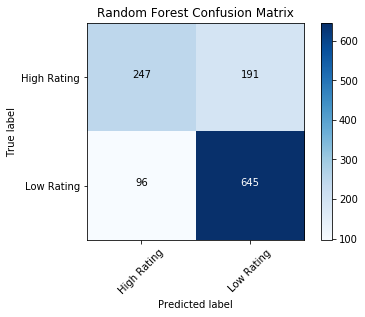

In [9]:
# Create the classifier, fit it on the training data and make predictions on the test set:
rforest = RandomForestClassifier(n_estimators=150, criterion = 'entropy', max_depth=None, max_features=8, 
                                 min_samples_split=5, random_state=123)
rforest.fit(X_train, y_train)
y_pred_test_rf = rforest.predict(X_test)
y_pred_train_rf = rforest.predict(X_train)

# Check the Accuracy:
print('Random Forest Train Accuracy: ', accuracy_score(y_train, y_pred_train_rf)*100,'%')
print('Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_test_rf)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred_test_rf))

# Confusion Matrix for Random Forest:
cm_forest = confusion_matrix(y_test,y_pred_test_rf)
confusion_matrix_plot(cm_forest, classes=class_names, title='Random Forest Confusion Matrix')

## 5.3 Adaboost:

Boosting is another type of ensamble method that leverages an ensamble of weak models to create a strong combined model. Whereas Random Forests trains each model independently, Boosting is an iterative method, using each model to strengthen the weaknessess of the previous model. With Adaboost (Adaptive Boosting), short (one-level) decision trees that are weak learners are added sequentially to the ensemble. Then, each subsequent model works to correct the weakeness made by the previous model. Adaboost is able to do this by weighing the training data to put a greater focus on training examples that had prediction errors in prior models. 

The metrics we will optimize here are:
- *n_estimators:* number of trees in the forest
- *learning_rate:* reduces the contribution of each classifier

In [13]:
# Determine optimal parameters:
# Declare a baseline classifier:
ada = AdaBoostClassifier()

# Create the grid parameter:
grid_ada = {'n_estimators': [30, 50, 70, 100, 200],
            'learning_rate': [1.0, 0.5, 0.1, .05, .01]}

# Create the grid:
gs_ada = GridSearchCV(ada, grid_ada, scoring='accuracy', cv=3, n_jobs=-1, return_train_score = True)

# Fit using grid search:
gs_ada.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_ada.best_score_)
print('\nBest params:\n', gs_ada.best_params_)

Best accuracy: 0.719

Best params:
 {'learning_rate': 1.0, 'n_estimators': 30}


Adaboost Train Accuracy:  74.15485278080698 %
Adaboost Test Accuracy:  74.72434266327396 %
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       438
           1       0.77      0.84      0.81       741

    accuracy                           0.75      1179
   macro avg       0.73      0.71      0.72      1179
weighted avg       0.74      0.75      0.74      1179



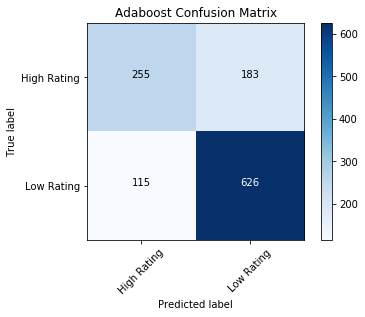

In [10]:
# Create the classifier, fit it on the training data and make predictions on the test set:
adab = AdaBoostClassifier(learning_rate=1.0, n_estimators = 30, random_state=123)

adab.fit(X_train, y_train)
y_pred_test_adab = adab.predict(X_test)
y_pred_train_adab = adab.predict(X_train)

# Check the Accuracy:
print('Adaboost Train Accuracy: ', accuracy_score(y_train, y_pred_train_adab)*100,'%')
print('Adaboost Test Accuracy: ', accuracy_score(y_test, y_pred_test_adab)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred_test_adab))

# Confusion Matrix for Random Forest:
cm_adab = confusion_matrix(y_test,y_pred_test_adab)
confusion_matrix_plot(cm_adab, classes=class_names, title='Adaboost Confusion Matrix')

## 5.4 XGBoost Classifier:

XGBoost is another boosting method that implements in the quickest, most performant way possible. It uses gradient boosting, which starts by calculating the overall loss of a weak learner and then uses the gradient and the loss as predictors of the next tree. 

The classifiers we are optimizing here are:
- *learning_rate:* reduces the contribution of each classifier
- *max_depth:* maximum number of levels of a tree
- *subsample:* fraction of observations to be randomly sampled for each tree.
- *gamma:* minimum loss reduction required to make a split
- *n_estimators:* number of trees in the forest

In [15]:
# Determine optimal parameters:
# Declare a baseline classifier:
xgb = XGBClassifier()

# Create the grid parameter:
grid_xgb = {'learning_rate': [1.0, 0.5, 0.1],
            'max_depth': [None, 3, 6, 9],
            'subsample': [.5, .7, 1],
            'gamma': [ 0.0, 0.1, 0.2],
            'n_estimators': [100, 150, 200]}

# Create the grid:
gs_xgb = GridSearchCV(xgb, grid_xgb, scoring='accuracy',
            cv=3, n_jobs=-1, return_train_score = True)

# Fit using grid search:
gs_xgb.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_xgb.best_score_)
print('\nBest params:\n', gs_xgb.best_params_)

Best accuracy: 0.729

Best params:
 {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


XGBoost Train Accuracy:  78.80770628862231 %
XGBoost Test Accuracy:  75.57251908396947 %
              precision    recall  f1-score   support

           0       0.72      0.57      0.63       438
           1       0.77      0.87      0.82       741

    accuracy                           0.76      1179
   macro avg       0.74      0.72      0.73      1179
weighted avg       0.75      0.76      0.75      1179



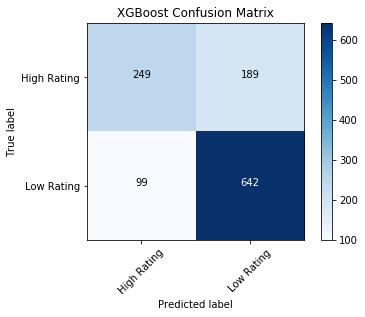

In [11]:
# Create the classifier, fit it on the training data and make predictions on the test set:
XGB = XGBClassifier(learning_rate=.1, n_estimators = 200, max_depth = 3, subsample = 1, gamma = .2, random_state=123)

XGB.fit(X_train, y_train)
y_pred_test_xgb = XGB.predict(X_test)
y_pred_train_xgb = XGB.predict(X_train)

# Check the Accuracy:
print('XGBoost Train Accuracy: ', accuracy_score(y_train, y_pred_train_xgb)*100,'%')
print('XGBoost Test Accuracy: ', accuracy_score(y_test, y_pred_test_xgb)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred_test_xgb))

# Confusion Matrix for Random Forest:
cm_xgb = confusion_matrix(y_test,y_pred_test_xgb)
confusion_matrix_plot(cm_xgb, classes=class_names, title='XGBoost Confusion Matrix')

## 5.5 Logistic Regression:

Regression is a technique used to predict a response variable from one or more predictor variables. There are 2 main types of regression, Linear and Logistic. Linear regression is used when the response variable is continuous and the regression line is linear. Logistic regression is used when the response variable is binary, and we get a sigmoid function (S-shaped). We will be using logistic regression as it is more apt for classification.

The metrics to optimize are:
- *penalty:* specifies the norm used in penalization
- *C:* controls the regularization (penalty) strength

In [17]:
# Determine optimal parameters:
# Declare a baseline classifier:
logreg = LogisticRegression()

# Create the grid parameter:
grid_log = {'penalty':['l1','l2'],
            'C':range(-4,4)}

# Create the grid:
gs_log = GridSearchCV(logreg, grid_log, scoring='accuracy', cv=3, return_train_score = True)

# Fit using grid search:
gs_log.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_log.best_score_)
print('\nBest params:\n', gs_log.best_params_)

Best accuracy: 0.724

Best params:
 {'C': 1, 'penalty': 'l2'}


Logistic Regression Train Accuracy:  75.7179207560887 %
Logistic Regession Test Accuracy:  74.6395250212044 %
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       438
           1       0.77      0.84      0.81       741

    accuracy                           0.75      1179
   macro avg       0.73      0.71      0.72      1179
weighted avg       0.74      0.75      0.74      1179



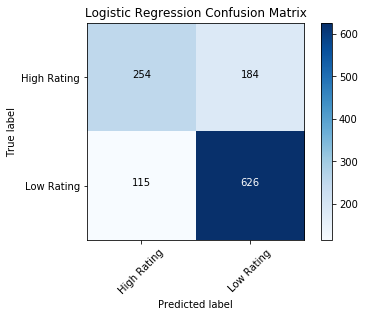

In [12]:
# Create the classifier, fit it on the training data and make predictions on the test set:
logr = LogisticRegression(penalty = 'l2', C = 1, random_state=123)

logr.fit(X_train, y_train)
y_pred_test_logr = logr.predict(X_test)
y_pred_train_logr = logr.predict(X_train)

# Check the Accuracy:
print('Logistic Regression Train Accuracy: ', accuracy_score(y_train, y_pred_train_logr)*100,'%')
print('Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_test_logr)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred_test_logr))

# Confusion Matrix for Random Forest:
cm_logr = confusion_matrix(y_test,y_pred_test_logr)
confusion_matrix_plot(cm_logr, classes=class_names, title='Logistic Regression Confusion Matrix')

Now that we have run all 5 of our models, let's take a look at all of their accuracy and F1 scores in order to determine which model we should proceed with. The F1 score is a harmonic mean of both precision (how accurate the predictions are) and the recall (% of positivies correctly identified).

In [13]:
# print the accuracy score of each model:
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
print('Decision Tree Test Accuracy: ', accuracy_score(y_test, y_pred_test_d_tree)*100,'%')
print('Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_test_rf)*100,'%')
print('Adaboost Test Accuracy: ', accuracy_score(y_test, y_pred_test_adab)*100,'%')
print('XGBoost Test Accuracy: ', accuracy_score(y_test, y_pred_test_xgb)*100,'%')
print('Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_test_logr)*100,'%')

# Print the F1 score of each model:
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
print('Decision Tree F1 Score: ', f1_score(y_test, y_pred_test_d_tree))
print('Random Forest F1 Score: ', f1_score(y_test, y_pred_test_rf))
print('Adaboost F1 Score: ', f1_score(y_test, y_pred_test_adab))
print('XGBoost F1 Score: ', f1_score(y_test, y_pred_test_xgb))
print('Logistic Regession F1 Score: ', f1_score(y_test, y_pred_test_logr))

----------------------------------------
Accuracy
----------------------------------------
Decision Tree Test Accuracy:  70.22900763358778 %
Random Forest Test Accuracy:  75.65733672603902 %
Adaboost Test Accuracy:  74.72434266327396 %
XGBoost Test Accuracy:  75.57251908396947 %
Logistic Regession Test Accuracy:  74.6395250212044 %

----------------------------------------
Weighted F1 Score
----------------------------------------
Decision Tree F1 Score:  0.7719298245614035
Random Forest F1 Score:  0.818008877615726
Adaboost F1 Score:  0.8077419354838709
XGBoost F1 Score:  0.8167938931297711
Logistic Regession F1 Score:  0.8072211476466795


It looks like Random Forest is our most accurate model, though is closely followed by XGBoost. 

One factor I want to consider is that our data seems to be a bit imbalanced, with many more data points falling into the high ratings bucket vs. the low ratings bucket. Let's see if balancing the data would help improve any of our models. Adaboost and XGBoost already account for the imbalance so we just need to look at our Decision Tree, Random Forest, and Logistic Regression Models.

In [14]:
# Decision Tree
# Create the classifier with a balanced weight, fit it on the training data and make predictions on the test set:
d_tree_bal = DecisionTreeClassifier(criterion='gini',max_depth=9,min_samples_split=4, random_state=123, 
                                class_weight='balanced')
d_tree_bal = d_tree_bal.fit(X_train, y_train)
y_pred_test_d_tree_bal = d_tree_bal.predict(X_test)
y_pred_train_d_tree_bal = d_tree_bal.predict(X_train)


# Random Forest
# Create the classifier with a balanced weight, fit it on the training data and make predictions on the test set:
rforest_bal = RandomForestClassifier(n_estimators=150, criterion = 'entropy', max_depth=None, max_features=8, 
                                 min_samples_split=5, random_state=123, class_weight='balanced')
rforest_bal.fit(X_train, y_train)
y_pred_test_rf_bal = rforest_bal.predict(X_test)
y_pred_train_rf_bal = rforest_bal.predict(X_train)


# Logistic Regression
# Create the classifier with a balanced weight, fit it on the training data and make predictions on the test set:
logr_bal = LogisticRegression(penalty = 'l2', C = 1, random_state=123, class_weight='balanced')

logr_bal.fit(X_train, y_train)
y_pred_test_logr_bal = logr_bal.predict(X_test)
y_pred_train_logr_bal = logr_bal.predict(X_train)


# print the accuracy score of each model:
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
print('Original Decision Tree Test Accuracy: ', accuracy_score(y_test, y_pred_test_d_tree)*100,'%')
print('Balanced Decision Tree Test Accuracy: ', accuracy_score(y_test, y_pred_test_d_tree_bal)*100,'%')
print('Original Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_test_rf)*100,'%')
print('Balanced Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_test_rf_bal)*100,'%')
print('Adaboost Test Accuracy: ', accuracy_score(y_test, y_pred_test_adab)*100,'%')
print('XGBoost Test Accuracy: ', accuracy_score(y_test, y_pred_test_xgb)*100,'%')
print('Original Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_test_logr)*100,'%')
print('Balanced Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_test_logr_bal)*100,'%')


# Print the F1 score of each model:
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
print('Original Decision Tree F1 Score:', f1_score(y_test, y_pred_test_d_tree))
print('Balanced Decision Tree F1 Score: ', f1_score(y_test, y_pred_test_d_tree_bal))
print('Original Random Forest F1 Score: ', f1_score(y_test, y_pred_test_rf))
print('Balanced Random Forest F1 Score: ', f1_score(y_test, y_pred_test_rf_bal))
print('Adaboost F1 Score: ', f1_score(y_test, y_pred_test_adab))
print('XGBoost F1 Score: ', f1_score(y_test, y_pred_test_xgb))
print('Original Logistic Regession F1 Score: ', f1_score(y_test, y_pred_test_logr))
print('Balanced Logistic Regession F1 Score: ', f1_score(y_test, y_pred_test_logr_bal))

----------------------------------------
Accuracy
----------------------------------------
Original Decision Tree Test Accuracy:  70.22900763358778 %
Balanced Decision Tree Test Accuracy:  68.27820186598814 %
Original Random Forest Test Accuracy:  75.65733672603902 %
Balanced Random Forest Test Accuracy:  74.72434266327396 %
Adaboost Test Accuracy:  74.72434266327396 %
XGBoost Test Accuracy:  75.57251908396947 %
Original Logistic Regession Test Accuracy:  74.6395250212044 %
Balanced Logistic Regession Test Accuracy:  73.19762510602206 %

----------------------------------------
Weighted F1 Score
----------------------------------------
Original Decision Tree F1 Score: 0.7719298245614035
Balanced Decision Tree F1 Score:  0.7221396731054978
Original Random Forest F1 Score:  0.818008877615726
Balanced Random Forest F1 Score:  0.8015978695073235
Adaboost F1 Score:  0.8077419354838709
XGBoost F1 Score:  0.8167938931297711
Original Logistic Regession F1 Score:  0.8072211476466795
Balanced Lo

Interestingly, it looks like balancing actually leads to a slightly less accurate model. However, Random Forest is still our best performing model. 

Moving forward with our original Random Forest model, let's take a look at which of the top 30 features are most important.

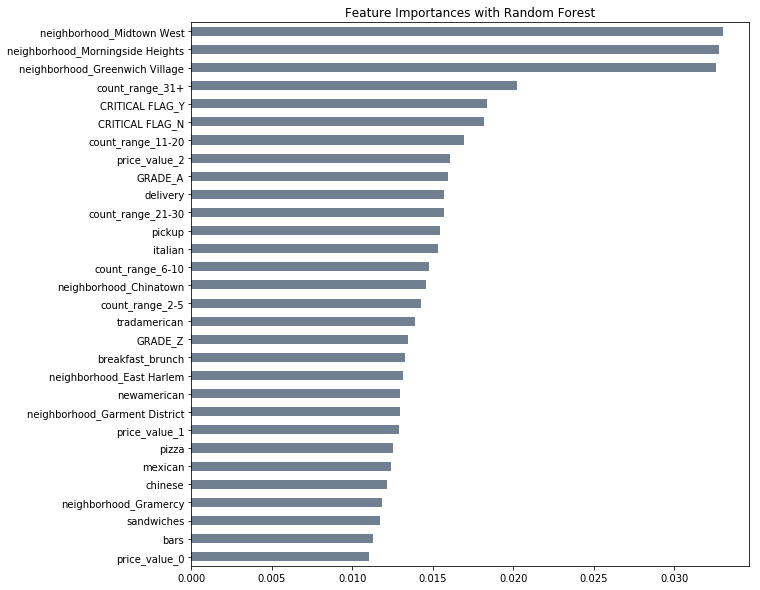

In [15]:
# Plot the 30 most influential features based on XGBoost model:
influential_features = pd.Series(rforest.feature_importances_, index=X.columns)
influential_features.nlargest(30).sort_values().plot(kind='barh', color='slategrey', figsize=(10,10))
plt.title('Feature Importances with Random Forest');

# Conclusion:

Out of our 5 Classification models, Random Forest is our most accurate model with an accuracy of 75.66% and an F1 score of 0.818. Within this model, the most influential features include a few neighborhoods such as Midtown West, Morningside Heights, and Greenwich Village along with having more than 31 inspection grade visits or 11-20 visits, receiving or not receiving a critical flag, and the price value of 2 dollar signs. 

From this analysis, a couple of things I would recommend to current or prospective restaurant owners include:
- If possible, consider opening a restaurant in Midtown West or Greenwich Village as restaurants in these neighborhoods tend to receive higher Yelp ratings and higher ratings can lead to drawing in more customers. Additionally, avoid opening a restaurant in Morningside Heights as these tend to receive lower Yelp ratings.
- Avoid receiving a critical violation flag in an inspection as having one of these violations likely leads to lower Yelp ratings, while not having a critical violation flag likely leads to higher Yelp ratings.



# Next Steps:

While this model is pretty accurate, there is still room to improve the model and become even more accurate. For example, further tuning the model by testing out additional hyperparameters in addition to the ones we have included here.

In addition to making this model more accurate, I am also interested in expanding this analysis beyond Manhattan and into the other NYC boroughs to see if the trends seen in Manhattan shift or remain the same in other boroughs.